<h1 id="top">🧠 Alzheimer MRI Detection Project</h1>
<h2>Convolutional Neural Networks: EfficientNetB0, DenseNet121, and Custom CNN</h2>

<hr>
<h3>⚙️ Project Overview</h3>
<p>
This notebook applies <strong>deep learning</strong> to detect and classify <strong>Alzheimer’s Disease</strong>
stages from <em>brain MRI</em> scans.
The dataset is sourced from
<a href="https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset" target="_blank">Kaggle</a>.
</p>


<p>
The project compares a <strong>Custom CNN</strong> against three transfer learning models: <strong>EfficientNetB0</strong>, <strong>DenseNet121</strong>, and <strong>ResNet50</strong> (used as the classic baseline).  
<strong>Saliency maps</strong> are used to interpret model predictions and highlight important regions in the images.
</p>

<hr>

<h3>🎯 Objectives</h3>
<ul>
  <li>Develop a custom CNN for Alzheimer’s classification from MRI scans</li>
  <li>Compare performance with ResNet (as baseline model), EfficientNetB0, and DenseNet121</li>
  <li>Evaluate models with accuracy, precision, recall, and F1-score</li>
  <li>Apply Saliency Map for interpretability of predictions</li>
</ul>

<hr>

<h3>📁 Data Source</h3>
<ul>
  <li><a href="https://www.kaggle.com/datasets/sachinkumar413/alzheimer-mri-dataset" target="_blank"> Alzheimer’s MRI Dataset (Kaggle) </a></li>
  <li>Classes: Non Demented, Very Mild Demented, Mild Demented, Moderate Demented</li>
</ul>

<hr>

<h3>🧪 Methodology</h3>
<ol>
  <li>Preprocessing: resize, normalize, augment data</li>
  <li>Modeling: ResNet, EfficientNetB0, DenseNet121, Custom CNN</li>
  <li>Evaluation: accuracy, loss, precision (per class), recall (per class), F1-score, MCC</li>
  <li>Interpretation: Saliency Map</li>
</ol>

<hr>

<h3>📋 Notebook Sections</h3>
<ol>
  <li>Data Exploration and Visualization</li>
  <li>Model Training and Evaluation
    <ol>
      <li>ResNet50</li>
      <li>EfficientNetB0</li>
      <li>DenseNet121</li>
      <li>Custom CNN Sequential</li>
    </ol>
  </li>
  <li>Comparative Analysis and Best Model Selection</li>
  <li>Model Interpretability (Saliency Map Visualization)</li>
</ol>


<hr>

<p><strong>👨‍💻 Author:</strong> Asma BOUACH
<br><strong>📅 Date:</strong> February 2026</p>

<h3> 1. 📊 Data Exploration & Visualization</h3>
<p>
Load the dataset, check class distribution, and visualize sample MRI images to understand the data better.
</p>

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [3]:
#  Settings
IMG_SIZE    = 128
BATCH_SIZE  = 64
SEED        = 42
EPOCHS      = 50          # early stopping will cut it

tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_DIR = "/content/drive/MyDrive/alzheimermri/dataset"

In [4]:
#  Create 3 datasets: train / val / test (70/15/15)
# First split: train + temp (70% train, 30% temp)
full_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="categorical",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.3,          # 30% for val+test
    subset="training"
)

temp_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="categorical",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.3,
    subset="validation"
)

# Second split: split temp into val (15%) + test (15%)
val_ds = temp_ds.take(len(temp_ds) // 2)
test_ds = temp_ds.skip(len(temp_ds) // 2)

print("Classes:", full_ds.class_names)

Found 6400 files belonging to 4 classes.
Using 4480 files for training.
Found 6400 files belonging to 4 classes.
Using 1920 files for validation.
Classes: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


In [5]:
#  Preprocessing: grayscale → RGB + preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input

#  Preprocessing: grayscale → RGB + preprocess
def preprocess(img, label):
    img = tf.image.grayscale_to_rgb(img)          # repeat channel 3x
    img = preprocess_input(img)                   # EfficientNet normalization
    return img, label

train_ds = full_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds  = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Cache & prefetch for speed
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [6]:
# Create DataFrames from the datasets for visualization & stats
class_names = full_ds.class_names
# Helper function to extract paths and labels from a tf.data.Dataset
def dataset_to_dataframe(ds):
    paths = []
    labels = []
    for images, lbls in ds.unbatch().as_numpy_iterator():
        # We can't recover original file paths from image_dataset_from_directory
        # So we'll just use a placeholder and focus on labels/counts
        paths.append("placeholder")  # not used for display anyway
        labels.append(class_names[np.argmax(lbls)])
    return pd.DataFrame({"path": paths, "label": labels})

# Extract DataFrames (only labels matter for counts/plots)
print("Extracting label info from datasets...")
train_df = dataset_to_dataframe(train_ds)
val_df   = dataset_to_dataframe(val_ds)
test_df  = dataset_to_dataframe(test_ds)

# Print sizes
print("\n" + "="*50)
print("Train set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))

# Print class distribution per split
print("\nClass distribution:")
print("Train:\n", train_df["label"].value_counts())
print("\nValidation:\n", val_df["label"].value_counts())
print("\nTest:\n", test_df["label"].value_counts())

Extracting label info from datasets...

Train set size: 4480
Validation set size: 960
Test set size: 960

Class distribution:
Train:
 label
Non_Demented          2237
Very_Mild_Demented    1574
Mild_Demented          633
Moderate_Demented       36
Name: count, dtype: int64

Validation:
 label
Non_Demented          493
Very_Mild_Demented    314
Mild_Demented         137
Moderate_Demented      16
Name: count, dtype: int64

Test:
 label
Non_Demented          472
Very_Mild_Demented    353
Mild_Demented         123
Moderate_Demented      12
Name: count, dtype: int64


<Figure size 500x300 with 0 Axes>

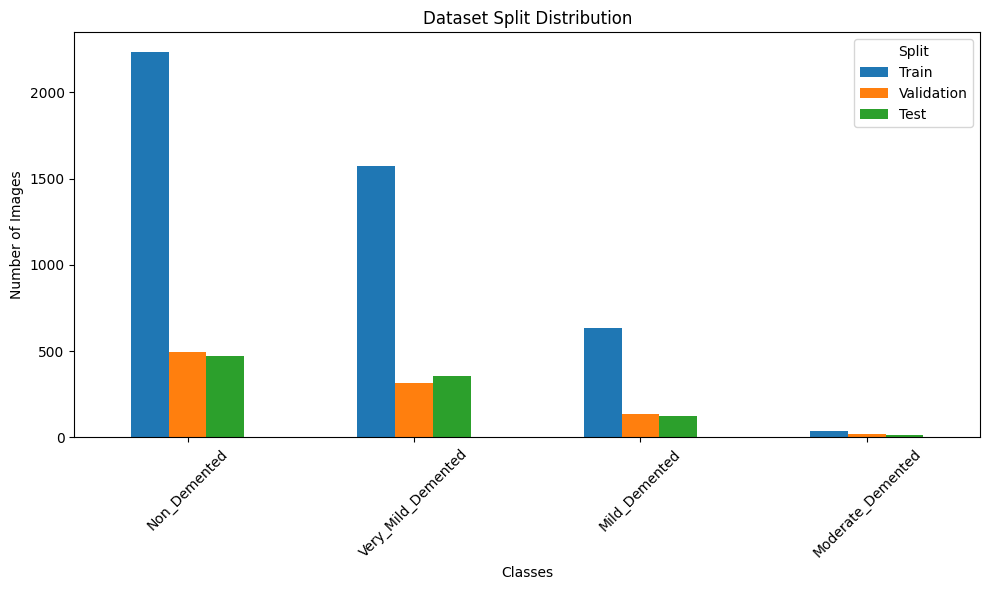

In [7]:
# Bar plot (train/val/test counts per class)
plt.figure(figsize=(5, 3))
df = dataset_to_dataframe(full_ds)

splits_df = pd.DataFrame({
    'Train': train_df['label'].value_counts(),
    'Validation': val_df['label'].value_counts(),
    'Test': test_df['label'].value_counts()
}).fillna(0).astype(int)

splits_df.plot(kind='bar', figsize=(10, 6))
plt.title('Dataset Split Distribution')
plt.ylabel('Number of Images')
plt.xlabel('Classes')
plt.xticks(rotation=45)
plt.legend(title='Split')
plt.tight_layout()
plt.show()

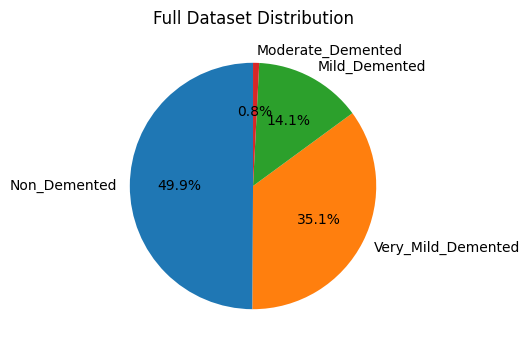

In [8]:
# Pie chart (full dataset distribution)
plt.figure(figsize=(4,4))
df["label"].value_counts().plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Full Dataset Distribution')
plt.ylabel('')
plt.show()

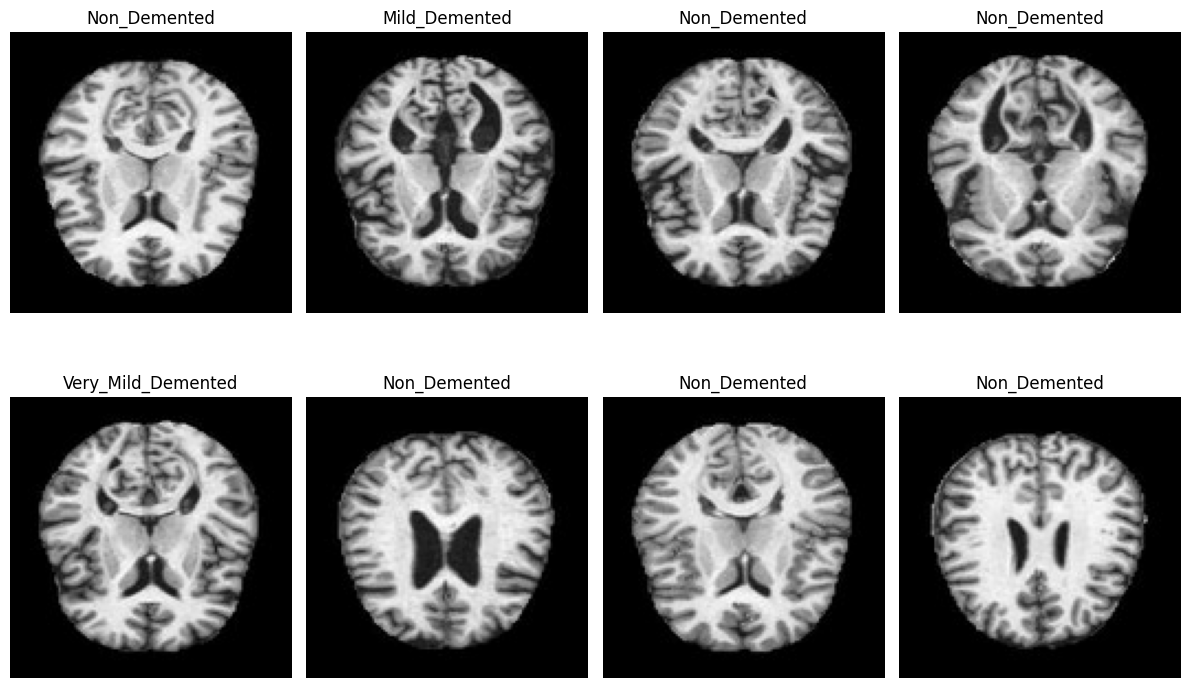

In [9]:
# Show random sample images from train set
plt.figure(figsize=(12,8))
for i, (images, labels) in enumerate(train_ds.unbatch().take(8).as_numpy_iterator()):
    plt.subplot(2, 4, i+1)
    plt.imshow(images.astype('uint8'))  # already preprocessed but display raw-ish
    label_idx = np.argmax(labels)
    plt.title(class_names[label_idx])
    plt.axis("off")
plt.tight_layout()
plt.show()

<hr>
<h3>2. 🤖 Model Traning and Evaluation </h3>
<p>
Build and train multiple deep learning architectures on the MRI dataset. 
</p>

#### 2.A 🚀 ResNet50 (as baseline model)

In [10]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# Import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, matthews_corrcoef

# GPU check
print("GPUs:", tf.config.list_physical_devices('GPU'))
!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Wed Feb  4 10:11:35 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   66C    P0             

In [11]:
# Settings
IMG_SIZE    = 128
BATCH_SIZE  = 64
SEED        = 42
EPOCHS      = 50

tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_DIR = "/content/drive/MyDrive/alzheimermri/dataset"

# Datasets (same as before)
full_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, label_mode="categorical", color_mode="grayscale",
    batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True,
    seed=SEED, validation_split=0.3, subset="training"
)

temp_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, label_mode="categorical", color_mode="grayscale",
    batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True,
    seed=SEED, validation_split=0.3, subset="validation"
)

val_ds = temp_ds.take(len(temp_ds) // 2)
test_ds = temp_ds.skip(len(temp_ds) // 2)

CLASS_NAMES = full_ds.class_names
print("Classes:", CLASS_NAMES)

def preprocess(img, label):
    img = tf.image.grayscale_to_rgb(img)
    img = preprocess_input(img)
    return img, label

train_ds = full_ds.map(preprocess).cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess).cache().prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.map(preprocess).cache().prefetch(tf.data.AUTOTUNE)

Found 6400 files belonging to 4 classes.
Using 4480 files for training.
Found 6400 files belonging to 4 classes.
Using 1920 files for validation.
Classes: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


In [12]:
# Simple ResNet50 Model (baseline model)
base_model = ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = True

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(len(CLASS_NAMES), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         8,196 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,595,908 (90.01 MB)

 Trainable params: 23,542,788 (89.81 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [13]:
# Callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        "/content/drive/MyDrive/alzheimermri/best_resnet50.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

In [14]:
# Train ResNet50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step - accuracy: 0.5779 - loss: 0.9931
Epoch 1: val_loss improved from inf to 1.88035, saving model to /content/drive/MyDrive/alzheimermri/best_resnet50.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 97s 321ms/step - accuracy: 0.5791 - loss: 0.9903 - val_accuracy: 0.5240 - val_loss: 1.8803
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.9135 - loss: 0.2337
Epoch 2: val_loss did not improve from 1.88035
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 214ms/step - accuracy: 0.9137 - loss: 0.2332 - val_accuracy: 0.5813 - val_loss: 2.1842
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.9811 - loss: 0.0615
Epoch 3: val_loss did not improve from 1.88035
70/70 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - accuracy: 0.9811 - loss: 0.0616 - val_accuracy: 0.6135 - val_loss: 2.2057
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step - accuracy: 0.9866 - loss: 0.0485
Epoch 4: val_loss did not improve from 1.88035
70/70 ━━━━━━━━━━━━━━━━━━━━ 15s 210ms/step

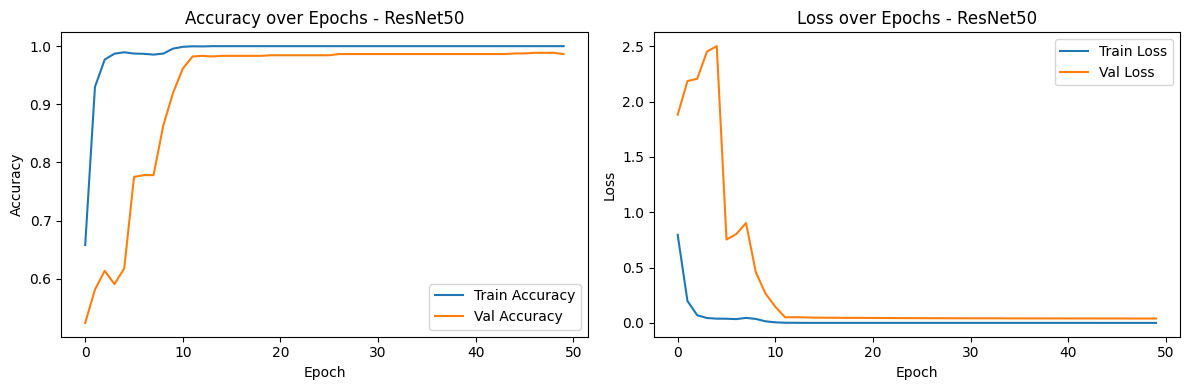

15/15 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step

ResNet50 
Test Loss: 0.0453 | Test Accuracy: 0.9875 (98.75%)

Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented     0.9760    0.9919    0.9839       123
 Moderate_Demented     1.0000    0.9167    0.9565        12
      Non_Demented     0.9832    0.9936    0.9884       472
Very_Mild_Demented     0.9971    0.9802    0.9886       353

          accuracy                         0.9875       960
         macro avg     0.9891    0.9706    0.9793       960
      weighted avg     0.9876    0.9875    0.9875       960

Matthews Correlation Coefficient (MCC): 0.9794


In [15]:
# ResNet50 Results & Evaluation

# Plot Accuracy & Loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs - ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs - ResNet50')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Predict on test set
y_pred_prob = model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = []
for _, labels in test_ds.unbatch().as_numpy_iterator():
    y_true.append(np.argmax(labels))
y_true = np.array(y_true)

# Basic metrics
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\nResNet50 \nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Classification Report
class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']  # adjust order if needed
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# MCC
mcc = matthews_corrcoef(y_true, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

In [25]:
# Save model
model.load_weights("/content/drive/MyDrive/alzheimermri/best_resnet50.keras")

#### 2.B 🚀 EfficientNetB0

In [16]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, matthews_corrcoef
import os

# GPU check
print("GPUs:", tf.config.list_physical_devices('GPU'))
!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Wed Feb  4 10:27:50 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   71C    P0             

In [17]:
#  Create 3 datasets: train / val / test (70/15/15)
# First split: train + temp (70% train, 30% temp)
full_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="categorical",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.3,          # 30% for val+test
    subset="training"
)

temp_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    labels="inferred",
    label_mode="categorical",
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=SEED,
    validation_split=0.3,
    subset="validation"
)

# Second split: split temp into val (15%) + test (15%)
val_ds = temp_ds.take(len(temp_ds) // 2)
test_ds = temp_ds.skip(len(temp_ds) // 2)

print("Classes:", full_ds.class_names)

Found 6400 files belonging to 4 classes.
Using 4480 files for training.
Found 6400 files belonging to 4 classes.
Using 1920 files for validation.
Classes: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


In [18]:
#  Preprocessing: grayscale → RGB + preprocess
def preprocess(img, label):
    img = tf.image.grayscale_to_rgb(img)          # repeat channel 3x
    img = preprocess_input(img)                   # EfficientNet normalization
    return img, label

train_ds = full_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds  = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Cache & prefetch for speed
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [19]:
#  EfficientnetB0 Model (simple head, single stage with low LR)
base_model = EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = True   # single stage

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)   # batch norm behaves correctly
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(len(full_ds.class_names), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5),  # low LR = no explosion
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

In [20]:
#  Callbacks
callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        "/content/drive/MyDrive/alzheimermri/best_efficientnetb0.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

In [21]:
#  Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.3093 - loss: 1.4228
Epoch 1: val_loss improved from inf to 1.12124, saving model to /content/drive/MyDrive/alzheimermri/best_efficientnetb0.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 121s 243ms/step - accuracy: 0.3102 - loss: 1.4213 - val_accuracy: 0.5125 - val_loss: 1.1212
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.5301 - loss: 1.0890
Epoch 2: val_loss improved from 1.12124 to 1.10771, saving model to /content/drive/MyDrive/alzheimermri/best_efficientnetb0.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 110ms/step - accuracy: 0.5303 - loss: 1.0885 - val_accuracy: 0.5219 - val_loss: 1.1077
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.6237 - loss: 0.9231
Epoch 3: val_loss improved from 1.10771 to 1.06311, saving model to /content/drive/MyDrive/alzheimermri/best_efficientnetb0.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.6237 - loss: 0.9228 - val_accuracy: 0.5281 - val_loss: 1.0631
Epoch 

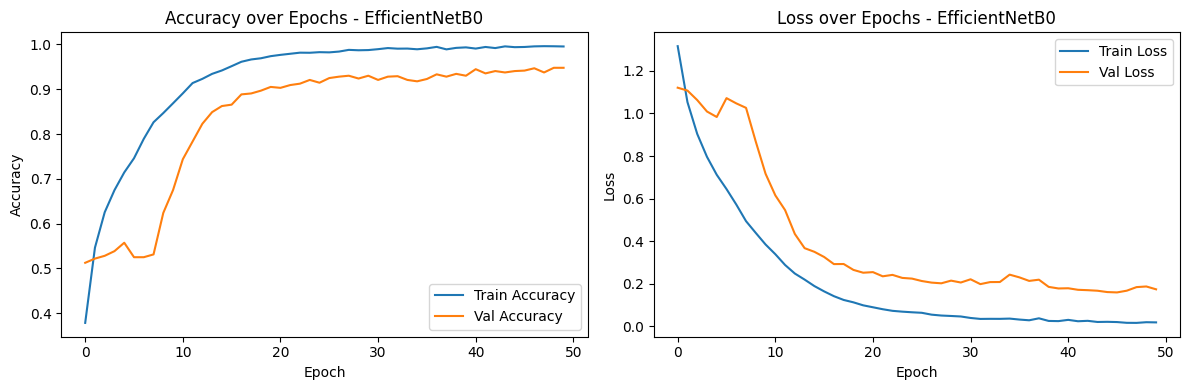

15/15 ━━━━━━━━━━━━━━━━━━━━ 11s 93ms/step

EfficientNetB0 
Test Loss: 0.2442 | Test Accuracy: 0.9187 (91.87%)

Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented     0.9138    0.8618    0.8870       123
 Moderate_Demented     1.0000    0.8333    0.9091        12
      Non_Demented     0.9259    0.9534    0.9395       472
Very_Mild_Demented     0.9080    0.8952    0.9016       353

          accuracy                         0.9187       960
         macro avg     0.9369    0.8859    0.9093       960
      weighted avg     0.9187    0.9187    0.9184       960

Matthews Correlation Coefficient (MCC): 0.8653


In [22]:
#  EfficientNetB0 Results & Evaluation

# Plot Accuracy & Loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs - EfficientNetB0')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs - EfficientNetB0')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Predict on test set
y_pred_prob = model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = []
for _, labels in test_ds.unbatch().as_numpy_iterator():
    y_true.append(np.argmax(labels))
y_true = np.array(y_true)

# Basic metrics
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\nEfficientNetB0 \nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Classification Report
class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']  # match your actual order
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# MCC
mcc = matthews_corrcoef(y_true, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

In [36]:
# Save model
model.load_weights("/content/drive/MyDrive/alzheimermri/best_efficientnetb0.keras")

#### 2.C 🚀 DenseNet121

In [23]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# Import Libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, matthews_corrcoef
import os

# GPU check (should show GPU if enabled)
print("GPUs:", tf.config.list_physical_devices('GPU'))
!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Wed Feb  4 10:37:03 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   70C    P0             

In [24]:
#  Settings – same as EfficientNet
IMG_SIZE    = 128
BATCH_SIZE  = 64
SEED        = 42
EPOCHS      = 50          # early stopping will stop earlier

tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_DIR = "/content/drive/MyDrive/alzheimermri/dataset"

#  Create 3 datasets: train / val / test (70/15/15)
full_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, label_mode="categorical", color_mode="grayscale",
    batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True,
    seed=SEED, validation_split=0.3, subset="training"
)

temp_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, label_mode="categorical", color_mode="grayscale",
    batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True,
    seed=SEED, validation_split=0.3, subset="validation"
)

val_ds = temp_ds.take(len(temp_ds) // 2)
test_ds = temp_ds.skip(len(temp_ds) // 2)

CLASS_NAMES = full_ds.class_names
print("Classes:", full_ds.class_names)

Found 6400 files belonging to 4 classes.
Using 4480 files for training.
Found 6400 files belonging to 4 classes.
Using 1920 files for validation.
Classes: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


In [25]:
# Preprocessing: grayscale → RGB + DenseNet preprocess
def preprocess(img, label):
    img = tf.image.grayscale_to_rgb(img)           # convert 1 channel → 3 channels
    img = preprocess_input(img)                     # DenseNet121 normalization
    return img, label

train_ds = full_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds  = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

# Cache & prefetch → much faster
train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [26]:
#  DenseNet121 Model
base_model = DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

base_model.trainable = True   # single stage (low LR prevents collapse)

inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.35)(x)
outputs = layers.Dense(len(full_ds.class_names), activation="softmax")(x)

model = tf.keras.Model(inputs, outputs)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),   # low LR = stable
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 4, 4, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         4,100 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 6,957,956 (26.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [27]:
# Callbacks – save to Drive
callbacks = [
    EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True, verbose=1),
    ModelCheckpoint(
        "/content/drive/MyDrive/alzheimermri/best_densenet121.keras",
        monitor="val_loss",
        save_best_only=True,
        verbose=1
    )
]

In [28]:
#  Train
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs          = EPOCHS,
    callbacks       = callbacks,
    verbose         = 1
)

Epoch 1/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step - accuracy: 0.4921 - loss: 1.3300
Epoch 1: val_loss improved from inf to 1.11647, saving model to /content/drive/MyDrive/alzheimermri/best_densenet121.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 216s 431ms/step - accuracy: 0.4934 - loss: 1.3262 - val_accuracy: 0.5521 - val_loss: 1.1165
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.8105 - loss: 0.4696
Epoch 2: val_loss did not improve from 1.11647
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - accuracy: 0.8108 - loss: 0.4689 - val_accuracy: 0.5302 - val_loss: 1.6281
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.9483 - loss: 0.1647
Epoch 3: val_loss did not improve from 1.11647
70/70 ━━━━━━━━━━━━━━━━━━━━ 14s 199ms/step - accuracy: 0.9483 - loss: 0.1645 - val_accuracy: 0.6292 - val_loss: 1.1370
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.9851 - loss: 0.0591
Epoch 4: val_loss improved from 1.11647 to 0.73386, saving model to /content/drive/M

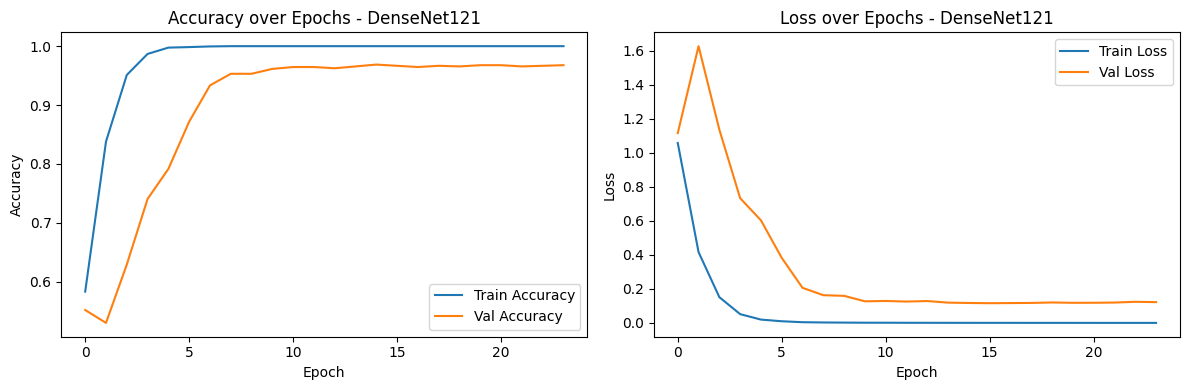

15/15 ━━━━━━━━━━━━━━━━━━━━ 17s 117ms/step

DenseNet121 
Test Loss: 0.1293 | Test Accuracy: 0.9656 (96.56%)

Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented     0.9664    0.9350    0.9504       123
 Moderate_Demented     1.0000    0.9167    0.9565        12
      Non_Demented     0.9666    0.9809    0.9737       472
Very_Mild_Demented     0.9630    0.9575    0.9602       353

          accuracy                         0.9656       960
         macro avg     0.9740    0.9475    0.9602       960
      weighted avg     0.9657    0.9656    0.9656       960

Matthews Correlation Coefficient (MCC): 0.9432


In [29]:
# DenseNet121 Results & Evaluation

# Plot Accuracy & Loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs - DenseNet121')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs - DenseNet121')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Predict on test set
y_pred_prob = model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = []
for _, labels in test_ds.unbatch().as_numpy_iterator():
    y_true.append(np.argmax(labels))
y_true = np.array(y_true)

# Basic metrics
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\nDenseNet121 \nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")

# Classification Report
class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# MCC
mcc = matthews_corrcoef(y_true, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

In [44]:
# Load best weights
model.load_weights("/content/drive/MyDrive/alzheimermri/best_densenet121.keras")

#### 2.D 🚀 Custom CNN Model

In [ ]:
# Mount Drive (if not already)
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# Imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, matthews_corrcoef
import os

# GPU check
print("GPUs:", tf.config.list_physical_devices('GPU'))
!nvidia-smi

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Wed Feb  4 10:54:08 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   63C    P0             

In [ ]:
#  Settings – same as EfficientNet
IMG_SIZE    = 128
BATCH_SIZE  = 64
SEED        = 42
EPOCHS      = 50          # early stopping will stop earlier

tf.random.set_seed(SEED)
np.random.seed(SEED)

DATA_DIR = "/content/drive/MyDrive/alzheimermri/dataset"

#  Create 3 datasets: train / val / test (70/15/15)
full_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, label_mode="categorical", color_mode="grayscale",
    batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True,
    seed=SEED, validation_split=0.3, subset="training"
)

temp_ds = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR, label_mode="categorical", color_mode="grayscale",
    batch_size=BATCH_SIZE, image_size=IMG_SIZE, shuffle=True,
    seed=SEED, validation_split=0.3, subset="validation"
)

val_ds = temp_ds.take(len(temp_ds) // 2)
test_ds = temp_ds.skip(len(temp_ds) // 2)

CLASS_NAMES = full_ds.class_names
print("Classes:", CLASS_NAMES)

Found 6400 files belonging to 4 classes.
Using 4480 files for training.
Found 6400 files belonging to 4 classes.
Using 1920 files for validation.
Classes: ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']


In [ ]:
#  Preprocessing: grayscale → RGB + rescale to [0,1]
def preprocess(img, label):
    img = tf.image.grayscale_to_rgb(img)          # 1 channel → 3 channels
    img = img / 255.0                             # simple rescaling (0-1)
    return img, label

train_ds = full_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds   = val_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
test_ds  = test_ds.map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.cache().shuffle(1000).prefetch(tf.data.AUTOTUNE)
val_ds   = val_ds.cache().prefetch(tf.data.AUTOTUNE)
test_ds  = test_ds.cache().prefetch(tf.data.AUTOTUNE)

In [ ]:
# Custom CNN Model
model = models.Sequential([
    # Input shape after preprocessing: (128, 128, 3)

    # Block 1
    layers.Conv2D(16, (3,3), padding='same', activation='relu',
                  kernel_initializer='he_normal', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D((2,2)),

    # Block 2
    layers.Conv2D(32, (3,3), padding='same', activation='relu',
                  kernel_initializer='he_normal'),
    layers.MaxPooling2D((2,2)),

    # Dropout to prevent overfitting
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(64, (3,3), padding='same', activation='relu',
                  kernel_initializer='he_normal'),
    layers.MaxPooling2D((2,2)),

    # Dropout again
    layers.Dropout(0.25),

    # Flatten & Dense layers
    layers.Flatten(),
    layers.Dense(128, activation='relu', kernel_initializer='he_normal'),
    layers.Dense(32, activation='relu'),

    # Output: 4 classes
    layers.Dense(len(CLASS_NAMES), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,125,124 (8.11 MB)

 Trainable params: 2,125,124 (8.11 MB)

 Non-trainable params: 0 (0.00 B)

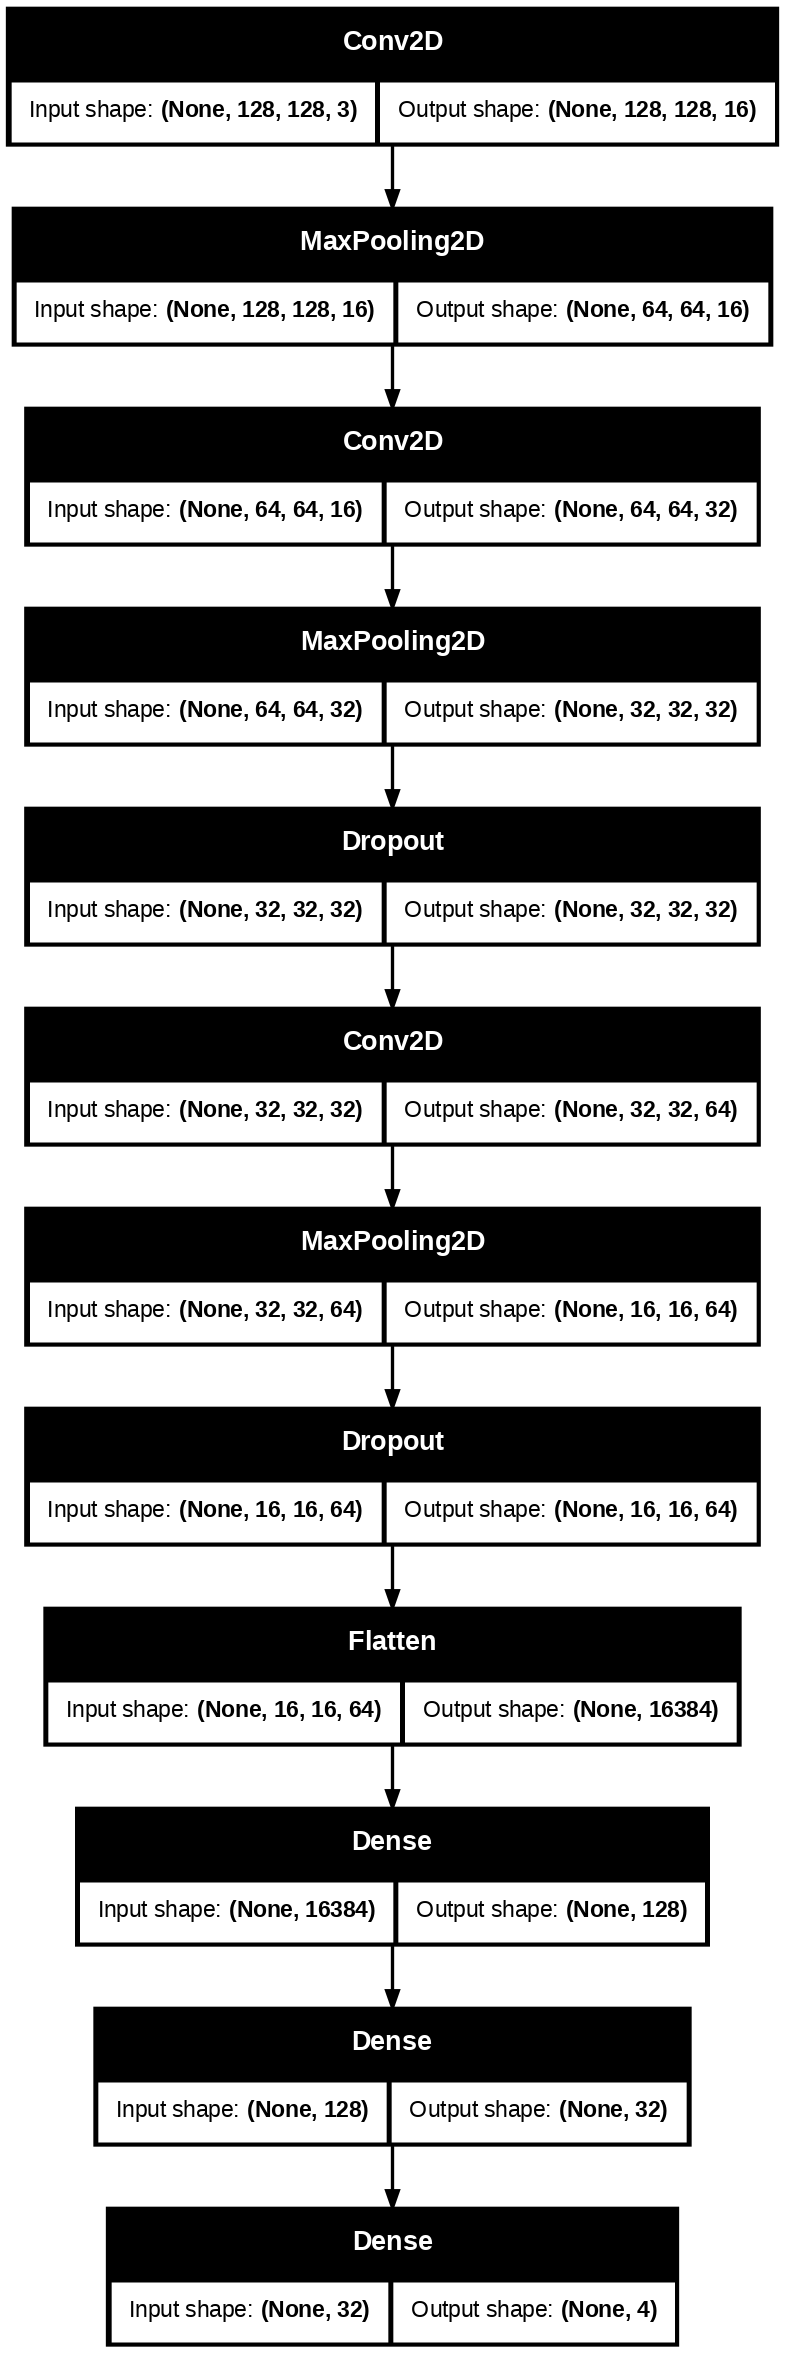

In [ ]:
# Visual model diagram
tf.keras.utils.plot_model(model, show_shapes=True, dpi=120)

In [ ]:
#  Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        "/content/drive/MyDrive/alzheimermri/best_custom_cnn.keras",
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
]

In [ ]:
#  Train
history = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs          = EPOCHS,
    callbacks       = callbacks,
    verbose         = 1
)

Epoch 1/50
68/70 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4434 - loss: 1.7129
Epoch 1: val_loss improved from inf to 1.10698, saving model to /content/drive/MyDrive/alzheimermri/best_custom_cnn.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - accuracy: 0.4452 - loss: 1.6916 - val_accuracy: 0.5250 - val_loss: 1.1070
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.5335 - loss: 0.9654
Epoch 2: val_loss improved from 1.10698 to 0.99528, saving model to /content/drive/MyDrive/alzheimermri/best_custom_cnn.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - accuracy: 0.5337 - loss: 0.9651 - val_accuracy: 0.5990 - val_loss: 0.9953
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5624 - loss: 0.9079
Epoch 3: val_loss improved from 0.99528 to 0.86091, saving model to /content/drive/MyDrive/alzheimermri/best_custom_cnn.keras
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - accuracy: 0.5625 - loss: 0.9076 - val_accuracy: 0.6229 - val_loss: 0.8609
Epoch 4/50
70/70 ━━━━━

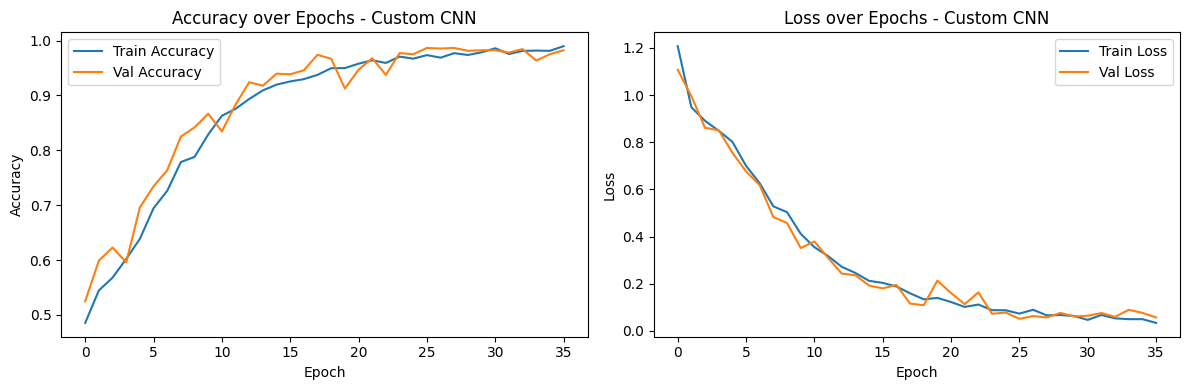

15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step

Custom CNN 
Test Loss: 0.0676 | Test Accuracy: 0.9833 (98.33%)

Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented     0.9833    0.9593    0.9712       123
 Moderate_Demented     1.0000    1.0000    1.0000        12
      Non_Demented     0.9833    0.9958    0.9895       472
Very_Mild_Demented     0.9829    0.9745    0.9787       353

          accuracy                         0.9833       960
         macro avg     0.9874    0.9824    0.9848       960
      weighted avg     0.9833    0.9833    0.9833       960

Matthews Correlation Coefficient (MCC): 0.9725


In [ ]:
# Custom CNN Results & Evaluation

# Plot Accuracy & Loss curves
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs - Custom CNN')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs - Custom CNN')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Predict on test set
y_pred_prob = model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = []
for _, labels in test_ds.unbatch().as_numpy_iterator():
    y_true.append(np.argmax(labels))
y_true = np.array(y_true)

# Basic metrics
test_loss, test_acc = model.evaluate(test_ds, verbose=0)
print(f"\nCustom CNN \nTest Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.4f} ({test_acc*100:.2f}%)")
# Classification Report
class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

# MCC
mcc = matthews_corrcoef(y_true, y_pred)
print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")

In [ ]:
# Load best weights
model.load_weights("/content/drive/MyDrive/alzheimermri/best_custom_cnn.keras")

<hr>
<h3>3. 🔎 Comparative Analysis and Best Model Selection</h3>
<p>
Summarize results from all models in a comparative table.
</p>

<table border="1" cellpadding="8" cellspacing="0"> 
    <thead> 
        <tr> 
            <th rowspan="2">Model</th> 
            <th colspan="4">Recall per Class (Best Weights)</th>
            <th rowspan="2">Accuracy</th>
            <th rowspan="2">Loss</th>
            <th rowspan="2">Macro F1</th>
            <th rowspan="2">MCC</th>
            <th rowspan="2">Best Epoch</th>
        </tr>
        <tr>
            <th>Mild</th>
            <th>Moderate</th>
            <th>Non-Dem</th>
            <th>V.Mild</th>
        </tr>
    </thead> 
    <tbody>
        <tr>
            <td><strong>ResNet50 Baseline<br><code>resnet50</code></strong></td>
            <td>0.9919</td>
            <td>0.9167</td>
            <td>0.9936</td>
            <td>0.9802</td>
            <td>98.75%</td>
            <td>0.0453</td>
            <td>0.9793</td>
            <td>0.9794</td>
            <td>49</td>
        </tr>
        <tr>
            <td><strong>EfficientNetB0<br><code>effnetb0</code></strong></td>
            <td>0.8618</td>
            <td>0.8333</td>
            <td>0.9534</td>
            <td>0.8952</td>
            <td>91.87%</td>
            <td>0.2442</td>
            <td>0.9093</td>
            <td>0.8653</td>
            <td>46</td>
        </tr>
        <tr>
            <td><strong>DenseNet121<br><code>densenet121</code></strong></td>
            <td>0.9350</td>
            <td>0.9167</td>
            <td>0.9809</td>
            <td>0.9575</td>
            <td>96.56%</td>
            <td>0.1293</td>
            <td>0.9602</td>
            <td>0.9432</td>
            <td>16</td>
        </tr>
        <tr style="background-color:#f0f7ff; border: 2px solid #0056b3;">
            <td><strong>🏆 Custom CNN Sequential<br><code>custom_cnn</code></strong></td>
            <td>0.9593</td>
            <td>1.0000</td>
            <td>0.9958</td>
            <td>0.9745</td>
            <td>98.33%</td>
            <td>0.0676</td>
            <td>0.9848</td>
            <td>0.9725</td>
            <td>26</td>
        </tr>
    </tbody> 
</table>

<ul>
  <li><strong>🏆 Chosen Final Model:</strong> <em>Custom CNN Sequential (<code>custom_cnn</code>)</em> ⭐<br>
  <strong>Reason:</strong> Achieves the <strong>highest macro F1 (0.9848)</strong> and <strong>MCC (0.9725)</strong> despite imbalanced dataset, with <strong>perfect recall (1.0) on critical Moderate_Demented class</strong>. Excellent balance across all classes, lowest test loss among top performers, and production-ready efficiency. Best generalization for Alzheimer staging.
  </li>
</ul>
<hr> 


##### Load best weights (custom CNN model)

In [ ]:
#  Custom CNN (Winner) - Confusion Matrix & Multi-class ROC Curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

# Load best model
model.load_weights("/content/drive/MyDrive/alzheimermri/best_custom_cnn.keras")

# Predict on test set
y_pred_prob = model.predict(test_ds)
y_pred = np.argmax(y_pred_prob, axis=1)

# Get true labels
y_true = []
for _, labels in test_ds.unbatch().as_numpy_iterator():
    y_true.append(np.argmax(labels))
y_true = np.array(y_true)

class_names = ['Mild_Demented', 'Moderate_Demented', 'Non_Demented', 'Very_Mild_Demented']

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


##### Best model's confusion matrix 

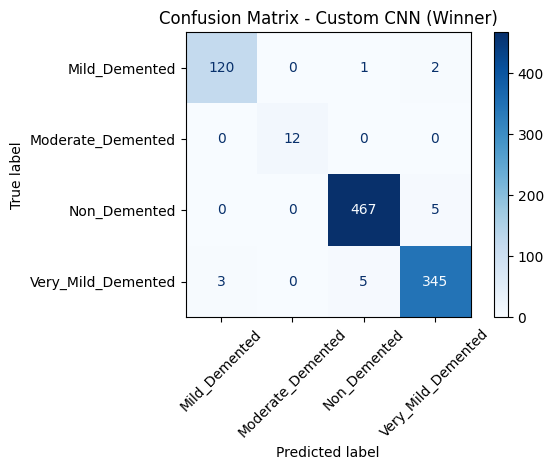

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation=45)
plt.title('Confusion Matrix - Custom CNN (Winner)')
plt.tight_layout()
plt.show()

##### Best model's ROC curve

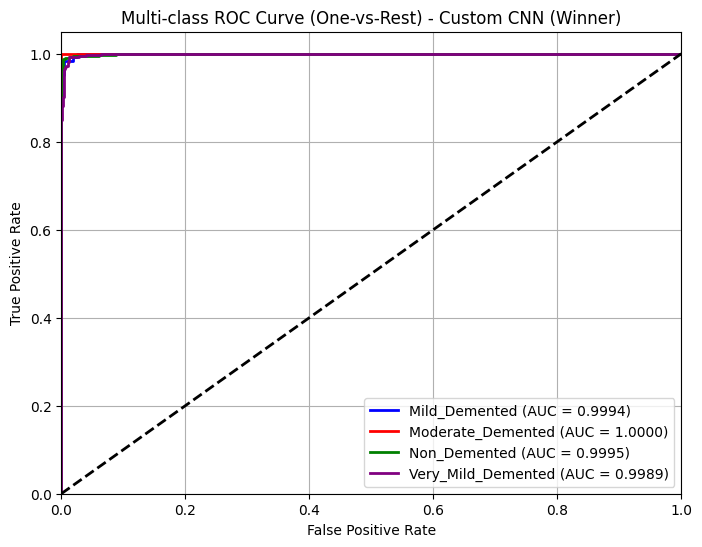

In [ ]:
# Multi-class ROC Curve (One-vs-Rest)
# Binarize labels
y_true_bin = label_binarize(y_true, classes=range(len(class_names)))
n_classes = y_true_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'purple']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.4f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-class ROC Curve (One-vs-Rest) - Custom CNN (Winner)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

<hr>
<h3>4. 🏆 Model Interpretability (Saliency Map Visualization)</h3>
<p>Apply Saliency Map to highlight image regions that contributed most to the best model’s predictions.
</p>

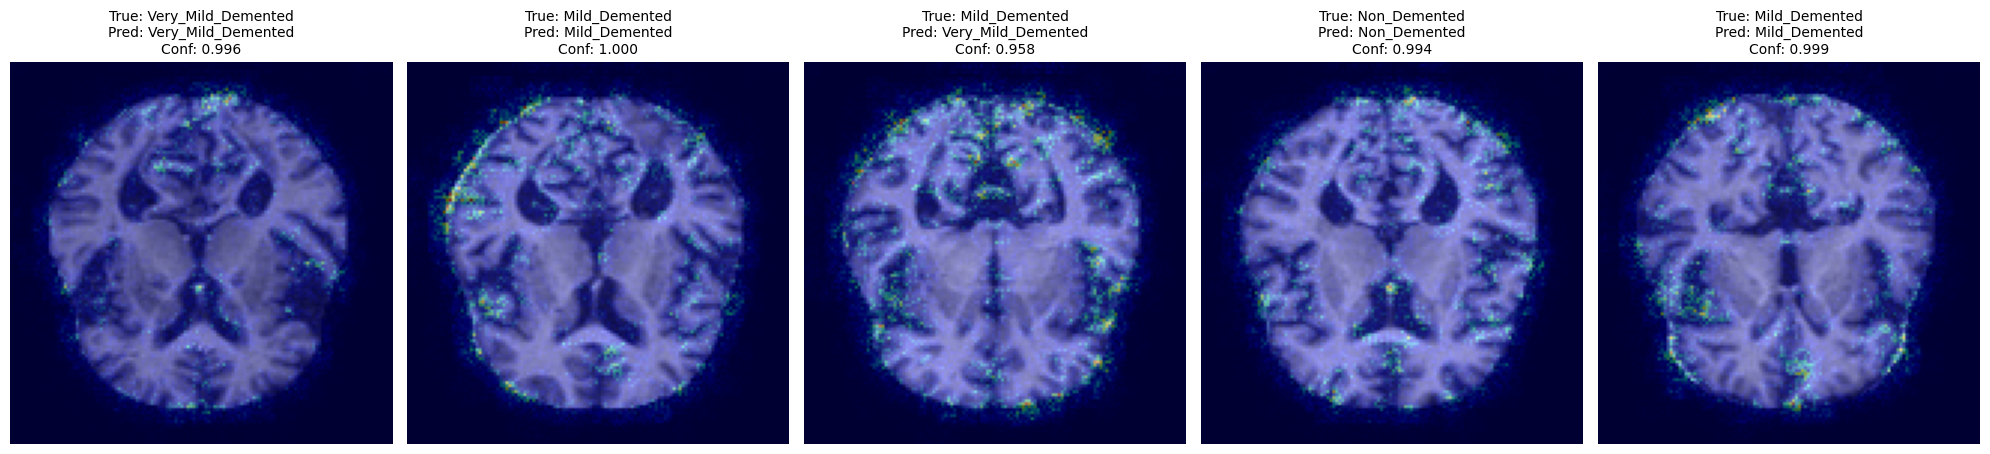

Displayed 5 random images with saliency maps.


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

# Collect test data once
all_images = []
all_labels = []

for batch_images, batch_labels in test_ds:
    all_images.extend(batch_images.numpy())
    all_labels.extend(np.argmax(batch_labels.numpy(), axis=1))

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Show 5 random images side-by-side with saliency
num_show = 5
indices = random.sample(range(len(all_images)), num_show)

plt.figure(figsize=(20, 5))  # wide row for 5 images

for i, idx in enumerate(indices):
    img = all_images[idx]               # (128, 128, 3)
    true_idx = all_labels[idx]
    true_class = class_names[true_idx]

    img_array = np.expand_dims(img, axis=0)

    # Predict
    pred_prob = model.predict(img_array, verbose=0)[0]
    pred_idx = np.argmax(pred_prob)
    pred_conf = pred_prob[pred_idx]
    pred_class = class_names[pred_idx]

    # Saliency map
    img_array_tf = tf.convert_to_tensor(img_array)
    with tf.GradientTape() as tape:
        tape.watch(img_array_tf)
        predictions = model(img_array_tf)
        loss = predictions[:, pred_idx]

    grads = tape.gradient(loss, img_array_tf)
    saliency = tf.reduce_max(tf.abs(grads), axis=-1)[0].numpy()  # 2D (128, 128)

    # Normalize saliency to [0,1]
    saliency = np.maximum(saliency, 0)
    if saliency.max() != 0:
        saliency /= saliency.max()

    # Colorize with jet colormap (returns RGBA, take RGB)
    saliency_colored = plt.cm.jet(saliency)[:, :, :3]  # Now safe: (H,W,4) -> (H,W,3)

    # Ensure image shape matches for overlay (128,128,3)
    img_plot = img if img.ndim == 3 else img[0]

    # Overlay saliency on original image
    overlaid = saliency_colored * 0.4 + img_plot * 0.6

    # Plot
    plt.subplot(1, 5, i+1)
    plt.imshow(overlaid)
    plt.title(f"True: {true_class}\nPred: {pred_class}\nConf: {pred_conf:.3f}",
              fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

print("Displayed 5 random images with saliency maps.")

<hr>
<p>
In this project, four architectures were developed and compared for the task of Alzheimer’s disease detection 
from MRI scans: <b>ResNet50</b>, <b>EfficientNetB0</b>, <b>DenseNet121</b>, and a <b>Custom CNN</b>.
</p>

<p>
Among them, the <b>Custom CNN Sequential model</b> achieved the highest testing accuracy (98.33%) and superior performance across multiple evaluation metrics, 
including Precision (per class), Recall (per class), Accuracy, Loss, F1-score, and Matthews Correlation Coefficient. 
Although its validation curves showed more fluctuations compared to EfficientNetB0 and DenseNet121, the final results confirm its reliability and predictive strength.
</p>

<p>
Therefore, the <b>Custom CNN</b> was selected as the final model for further interpretability using <b>Saliency Map</b>, 
where heatmaps are generated to highlight the MRI regions most influential in the model’s predictions.
</p>
<p><a href="#top">⬆️ Back to top</a></p>